<a href="https://colab.research.google.com/github/roundspecs/error-bar-detection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GDrive & GitHub

In [1]:
!git clone https://github.com/roundspecs/error-bar-detection.git error_bar_detection

Cloning into 'error_bar_detection'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 246 (delta 118), reused 179 (delta 58), pack-reused 0 (from 0)
Receiving objects: 100% (246/246), 1.23 MiB | 3.76 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [2]:
import os
os.chdir("/content/error_bar_detection")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from pathlib import Path
DATASET_PATH = Path('/content/drive/MyDrive/Delineate/data/')

In [5]:
if not os.path.exists('data'):
  os.symlink(DATASET_PATH, 'data')

# EDA

In [6]:
import os
from src.common.io import load_dataset

dataset = load_dataset(DATASET_PATH / 'cleaned')

Loading dataset from /content/drive/MyDrive/Delineate/data/cleaned...


KeyboardInterrupt: 

In [8]:
print(dataset[0].image_path)

/content/drive/MyDrive/Delineate/data/cleaned/images/043d958d-c6fb-407e-ba05-19ccf09017a2.png


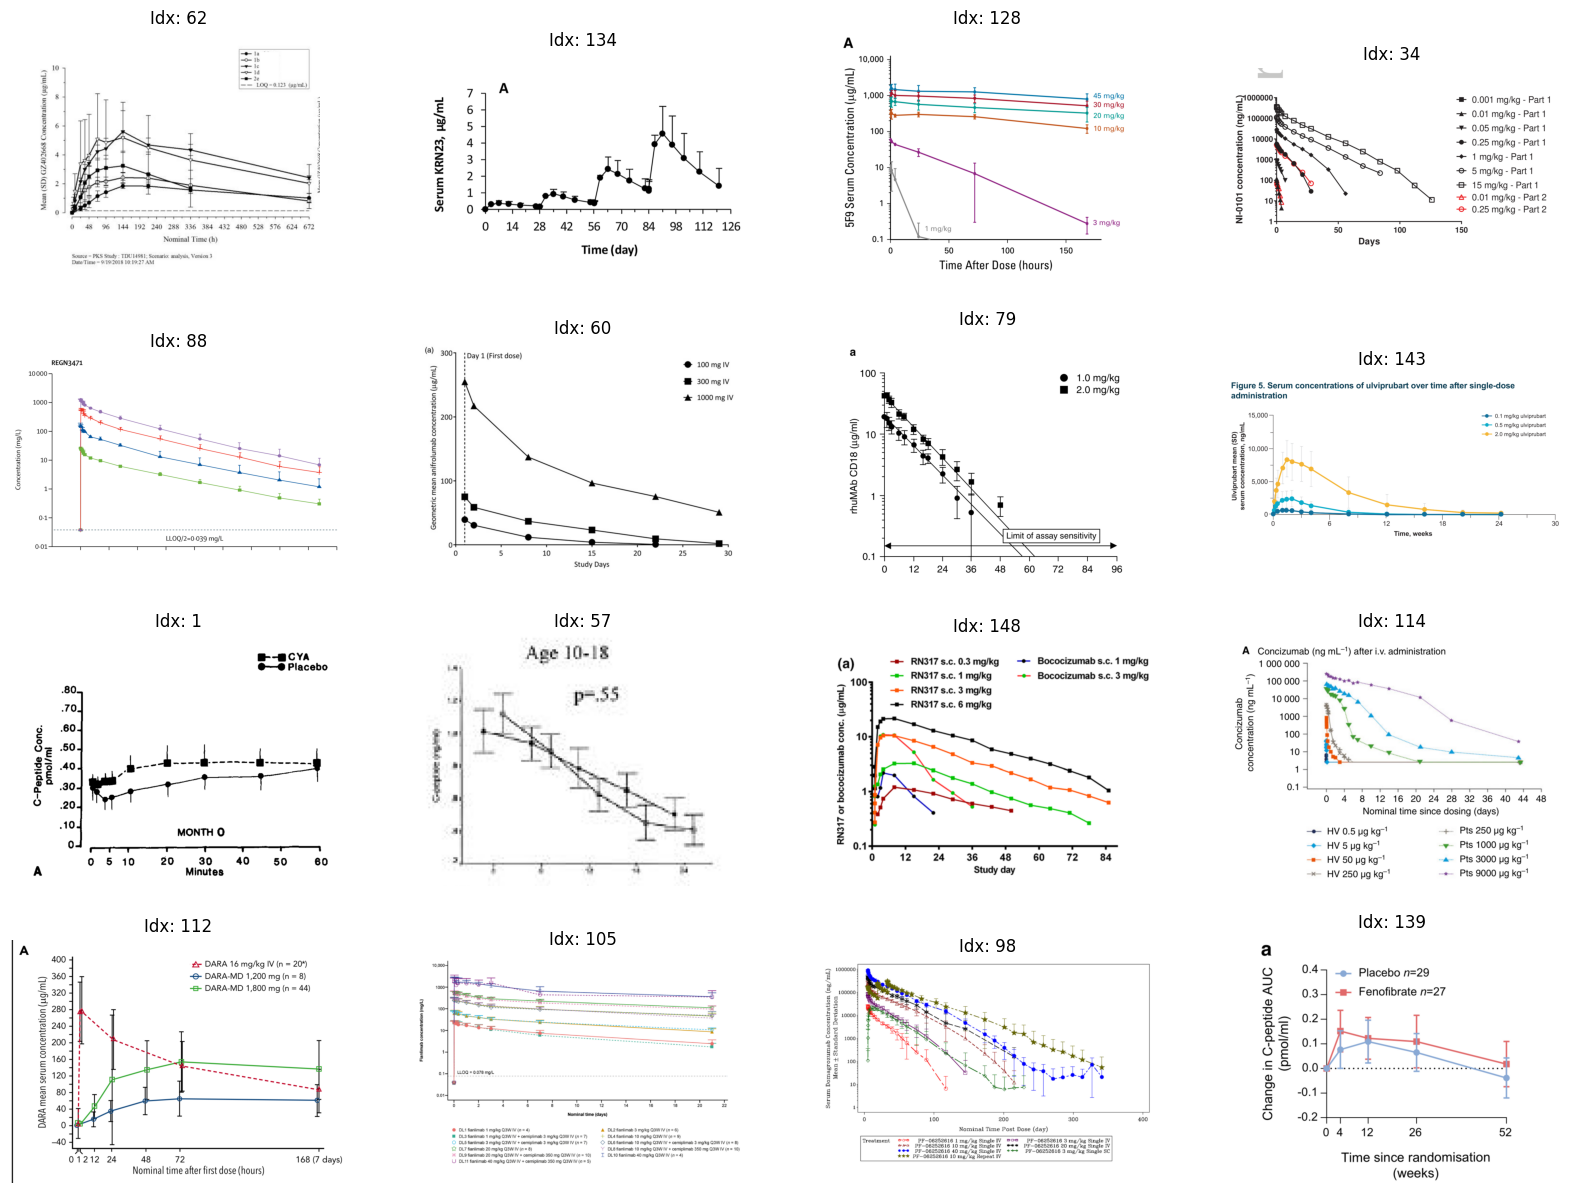

In [9]:
from matplotlib import pyplot as plt
import random

random_idx = [random.randint(0, len(dataset) - 1) for _ in range(16)]

fig, axs = plt.subplots(4, 4, figsize=(20, 15))
for i, idx in enumerate(random_idx):
  img = plt.imread(dataset[idx].image_path)
  axs[i%4][i//4].imshow(img)
  axs[i%4][i//4].set_title(f"Idx: {idx}")
  axs[i%4][i//4].set_axis_off()
plt.show()

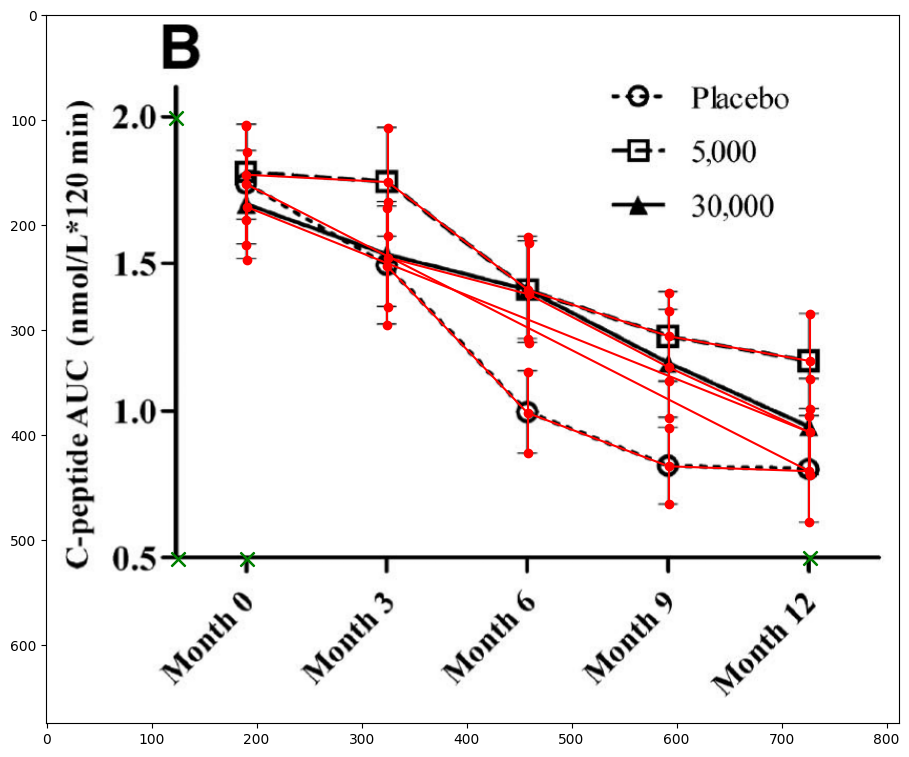

In [29]:
def visualize_sample(idx):
  img = plt.imread(dataset[idx].image_path)
  fig, ax = plt.subplots(figsize=(img.shape[0]//60, img.shape[1]//60))
  ax.imshow(img, cmap='gray')

  for line in dataset[idx].lines:
    x, y = [], []
    phantom_x, phantom_y = [], []
    for p in line.points:
      if p.label == '':
        x.append(p.x)
        y.append(p.y)
        ax.plot([p.x, p.x], [p.y - p.topBarPixelDistance, p.y + p.bottomBarPixelDistance], color='red', marker='o')
      else:
        phantom_x.append(p.x)
        phantom_y.append(p.y)
    ax.plot(x, y, color='red', marker='o')
    ax.scatter(phantom_x, phantom_y, color='green', marker='x', s=100)
    # ax.set_axis_off()
  plt.show()

visualize_sample(147)

## Cleaning: Bar height
Conclusion: Remove all points with total bar height > 410

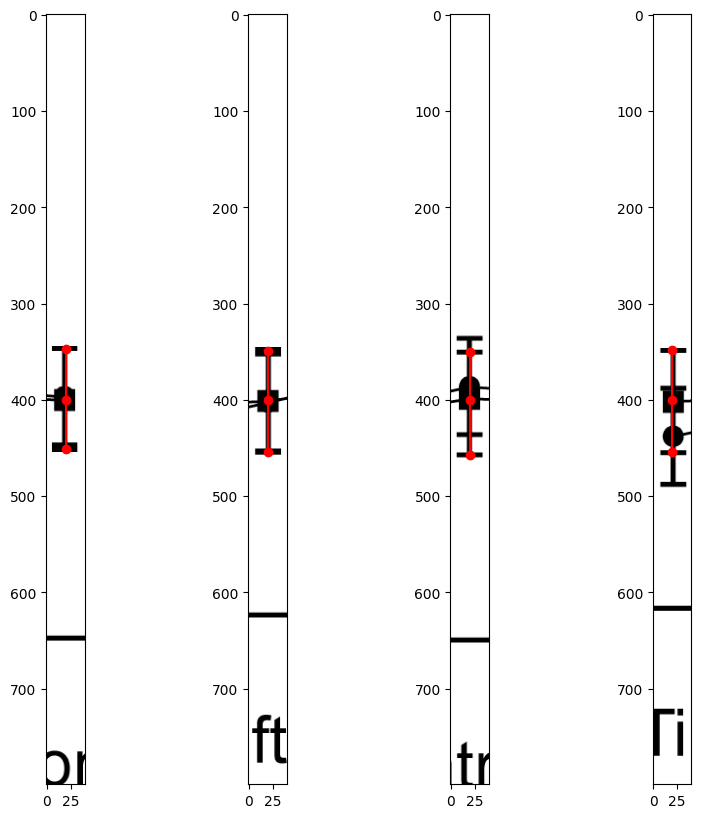

In [28]:
import numpy as np

def visualize_sample_bars(idx, line_no=0):
  img = plt.imread(dataset[idx].image_path)
  line = dataset[idx].lines[line_no]
  valid_points = [p for p in line.points if p.label == '']

  fig, axs = plt.subplots(1, len(valid_points), figsize=(10, 10))

  height_half = 400
  width_half = 20

  for i, p in enumerate(valid_points):
    x = int(p.x)
    y = int(p.y)

    y_start_img = max(0, y - height_half)
    y_end_img = min(img.shape[0], y + height_half)
    x_start_img = max(0, x - width_half)
    x_end_img = min(img.shape[1], x + width_half)

    actual_crop_content = img[y_start_img:y_end_img, x_start_img:x_end_img]

    canvas = np.ones((height_half * 2, width_half * 2, img.shape[2]), dtype=img.dtype)

    canvas_y_start = height_half - (y - y_start_img)
    canvas_y_end = canvas_y_start + actual_crop_content.shape[0]
    canvas_x_start = width_half - (x - x_start_img)
    canvas_x_end = canvas_x_start + actual_crop_content.shape[1]

    canvas[canvas_y_start:canvas_y_end, canvas_x_start:canvas_x_end] = actual_crop_content
    img_cropped = canvas

    axs[i].imshow(img_cropped)
    axs[i].plot([width_half, width_half, width_half], [height_half - p.topBarPixelDistance, height_half, height_half + p.bottomBarPixelDistance], color='red', marker='o')
    # axs[i].set_axis_off()
  plt.show()

visualize_sample_bars(21)

In [12]:
def bar_height_analysis():
  total_heights = []
  top_heights = []
  bottom_heights = []
  for i, image in enumerate(dataset):
    for line in image.lines:
      for point in line.points:
        total_height = point.topBarPixelDistance + point.bottomBarPixelDistance
        total_heights.append((total_height, i, image.id))
        top_heights.append((point.topBarPixelDistance, i, image.id))
        bottom_heights.append((point.bottomBarPixelDistance, i, image.id))

  print(f"Total bars: {len(total_heights)}")
  total_heights.sort(key=lambda x: x[0])
  top_heights.sort(key=lambda x: x[0])
  bottom_heights.sort(key=lambda x: x[0])
  print(f"Min total height: {total_heights[0][0]}")
  print(f"Max total height: {total_heights[-1][0]}")
  print(f"Min top height: {top_heights[0][0]}")
  print(f"Max top height: {top_heights[-1][0]}")
  print(f"Min bottom height: {bottom_heights[0][0]}")
  print(f"Max bottom height: {bottom_heights[-1][0]}")

bar_height_analysis()

Total bars: 6734
Min total height: 0.0
Max total height: 406.0
Min top height: 0.0
Max top height: 367.71435546875
Min bottom height: 0.0
Max bottom height: 295.5872802734375


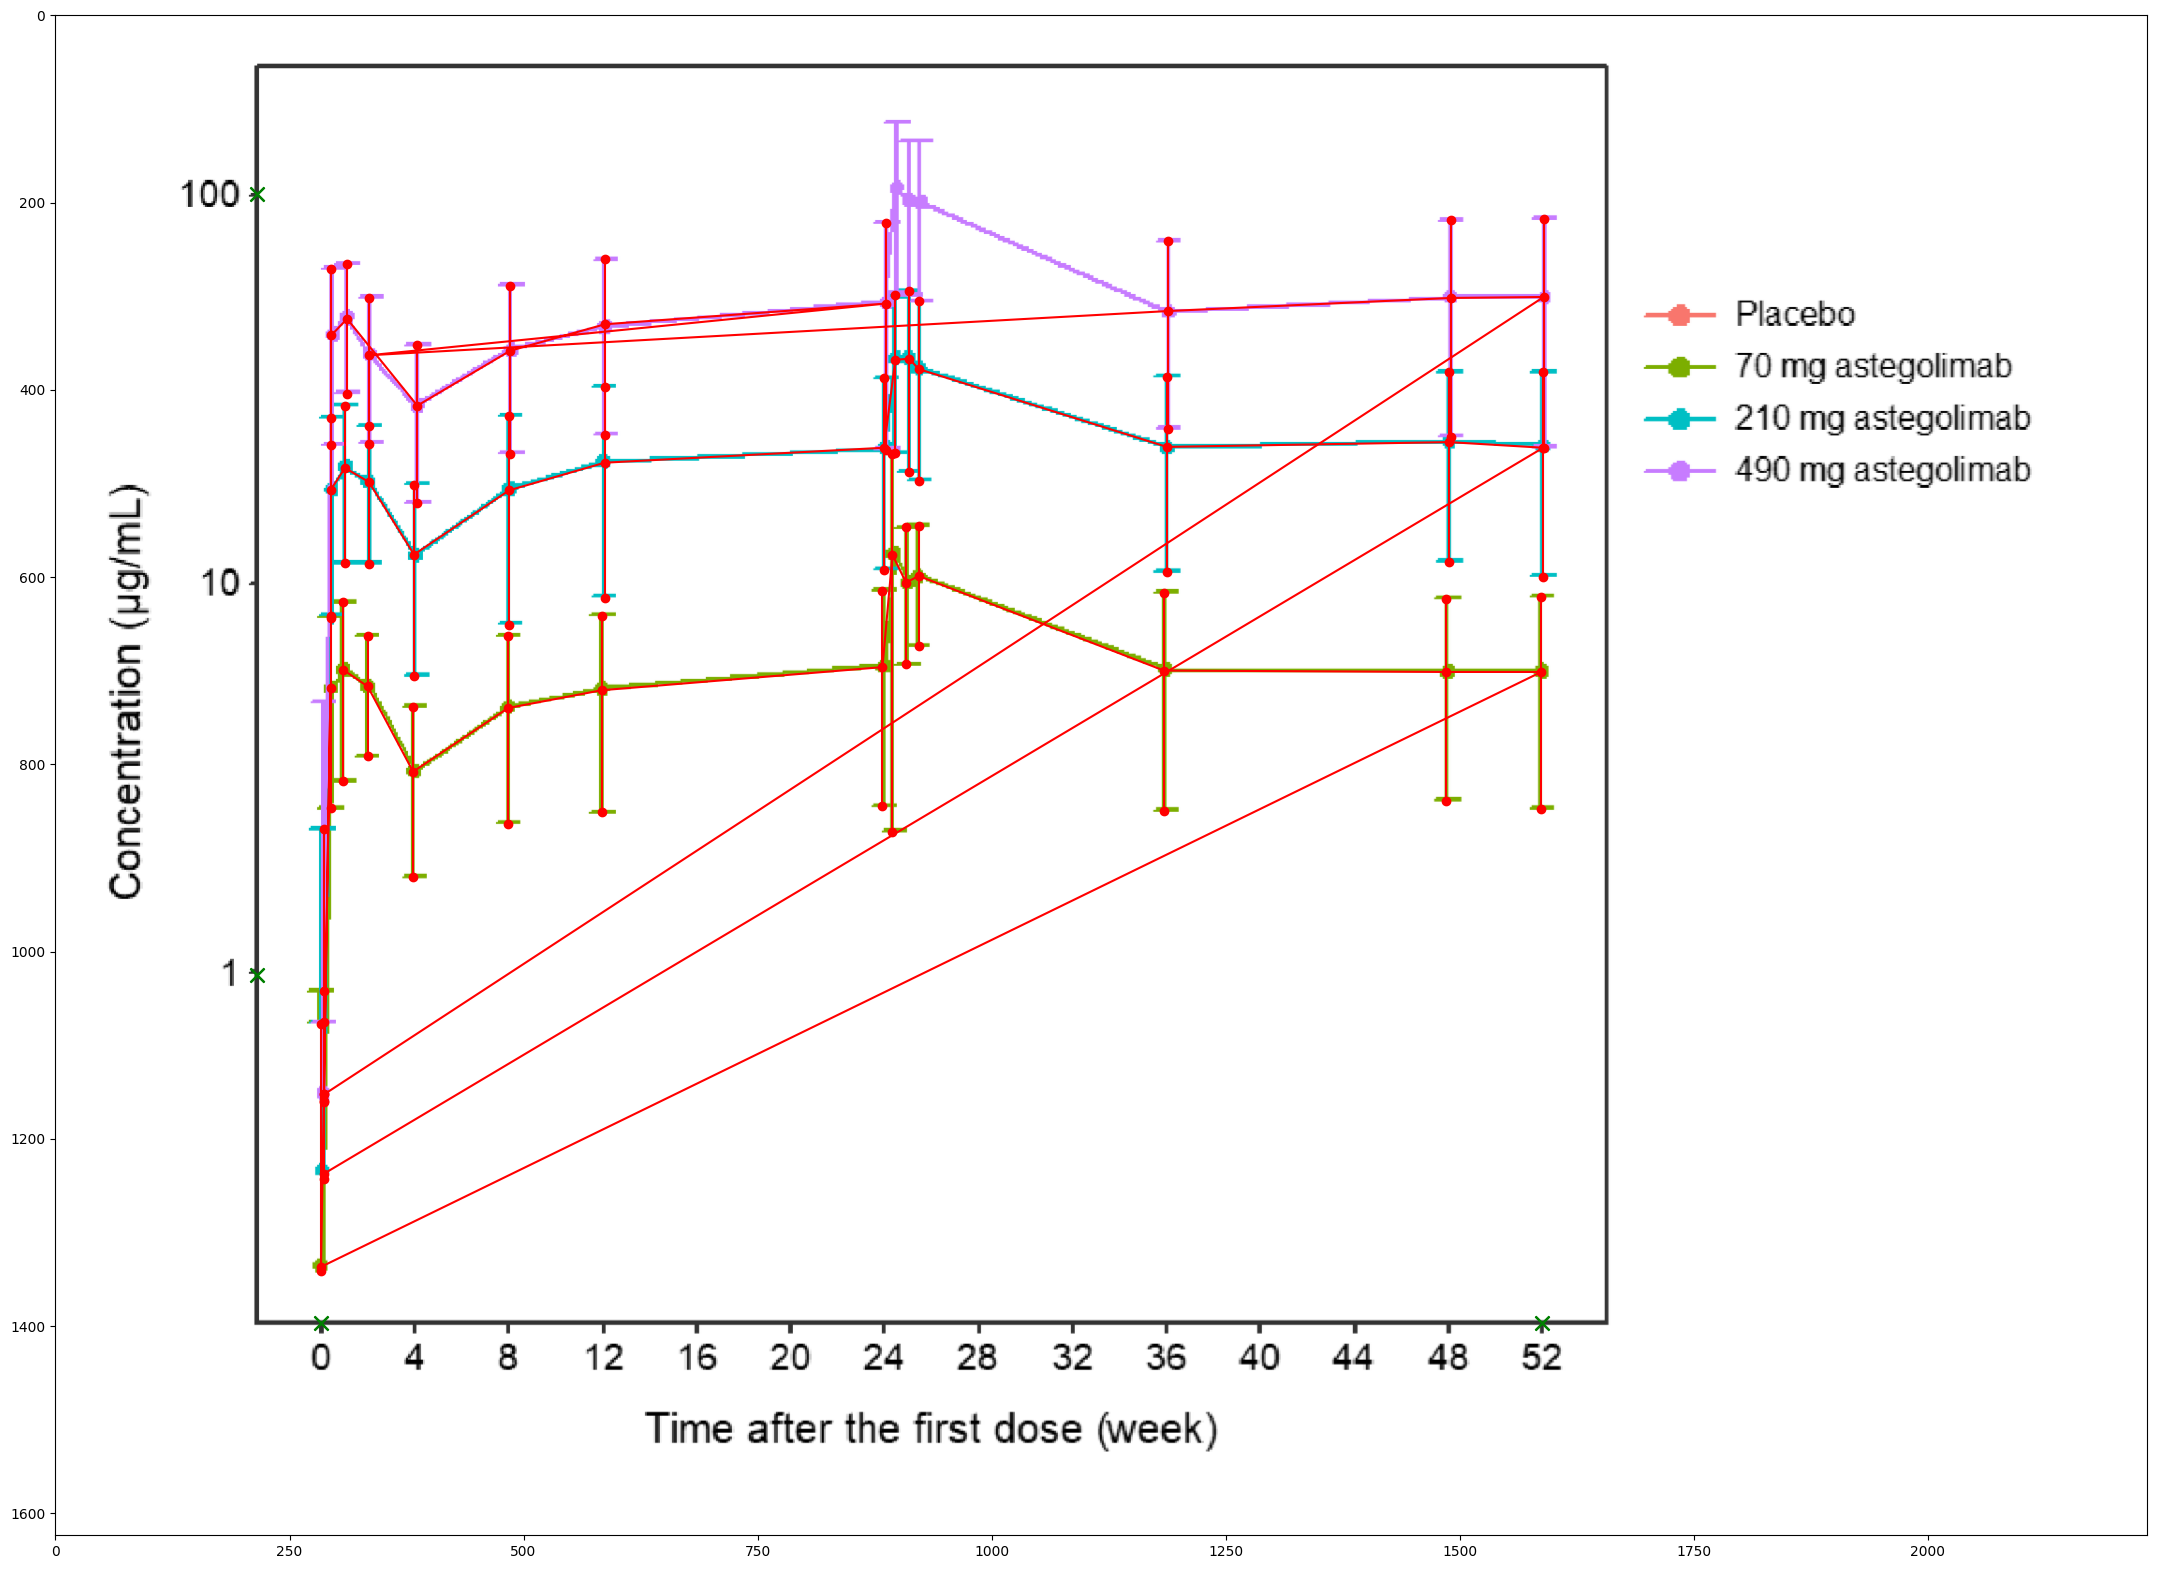

In [13]:
visualize_sample(70)

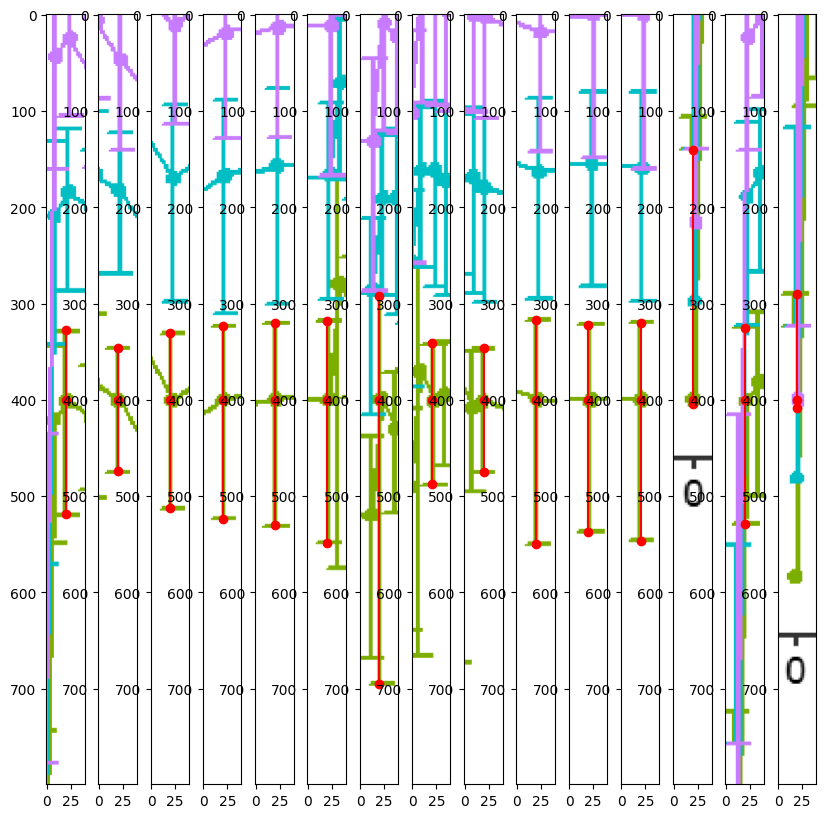

In [14]:
visualize_sample_bars(70, 2)

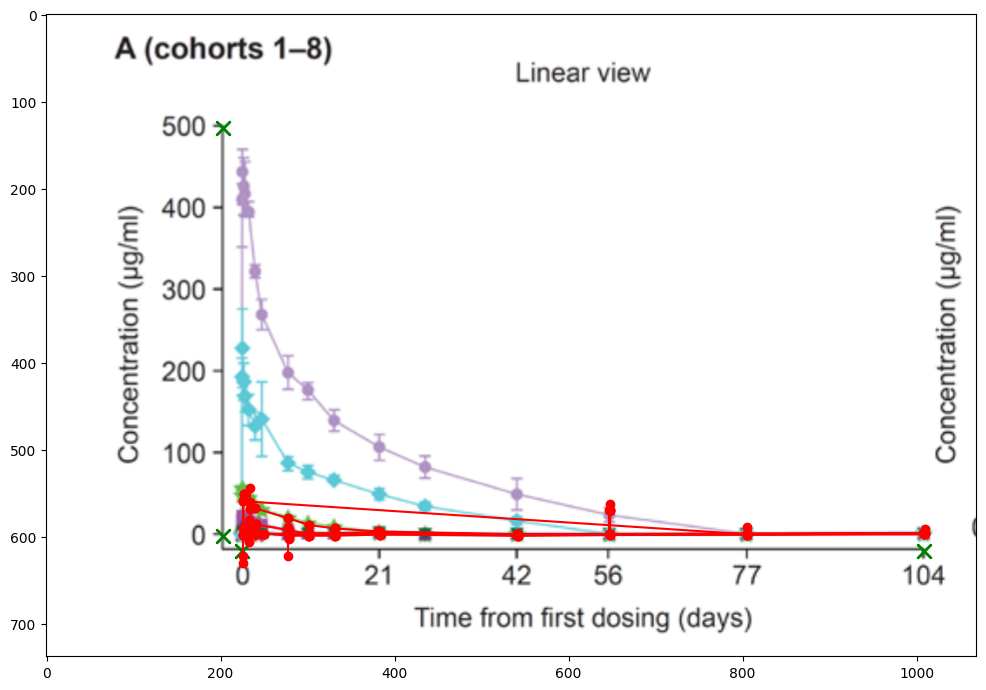

In [15]:
visualize_sample(37)

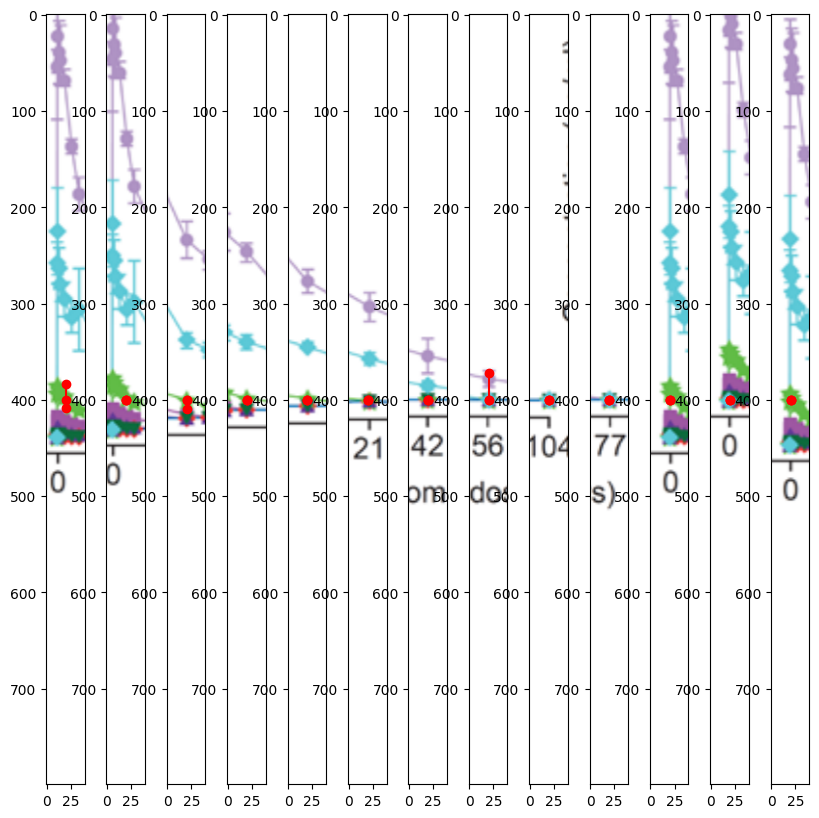

In [16]:
visualize_sample_bars(37)

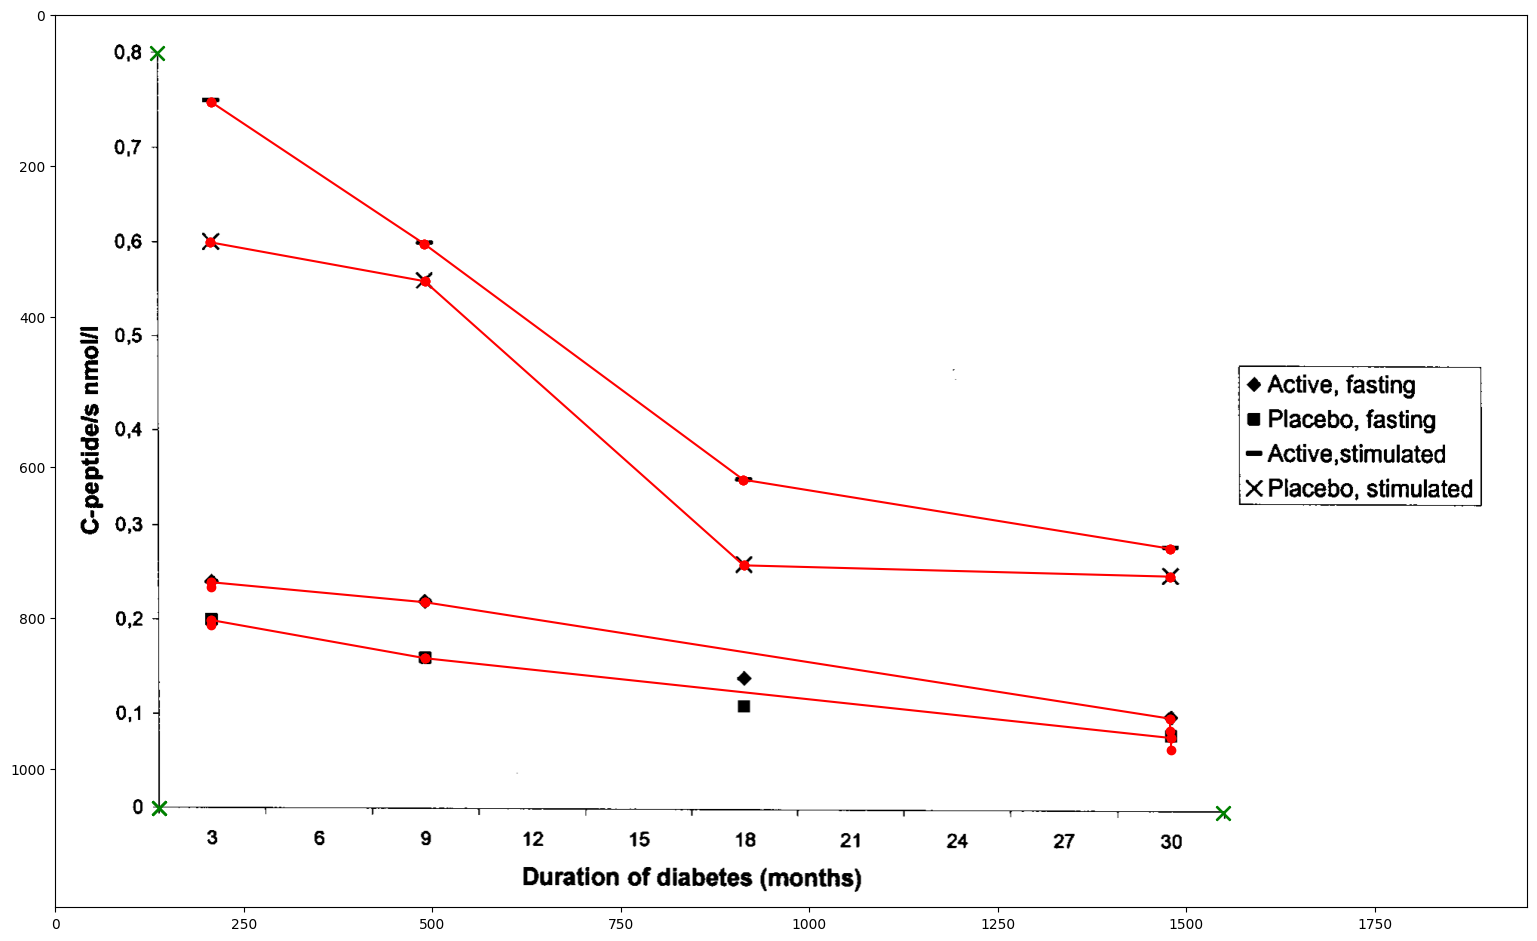

In [17]:
visualize_sample(138)

## Cleaning: Filename
Conclusion: All clean

In [18]:
import os

def check_image_for_all_labels_exists():
  does_not_exist = 0
  for image in dataset:
    if not os.path.exists(image.image_path):
      does_not_exist += 1
  print("Does not exist:", does_not_exist)

check_image_for_all_labels_exists()

Does not exist: 0


## Cleaning: Error bar falls within image
Conclusion: 116 violations exist

In [19]:
from collections import defaultdict

def check_error_bar_within_image():
  violations = 0
  violated_images = defaultdict(int)
  for i, image in enumerate(dataset):
    phantoms_y = {p.y for l in image.lines for p in l.points if len(p.label) != 0}
    min_y = min(phantoms_y)
    max_y = max(phantoms_y)
    image_height = plt.imread(image.image_path).shape[0]
    for line in image.lines:
      for p in line.points:
        if p.y-p.topBarPixelDistance < min_y - 15 or p.y+p.bottomBarPixelDistance > max_y + 15:
          violations += 1
          violated_images[i] += 1
  print(violated_images)
  return violations

check_error_bar_within_image()

defaultdict(<class 'int'>, {145: 39})


39

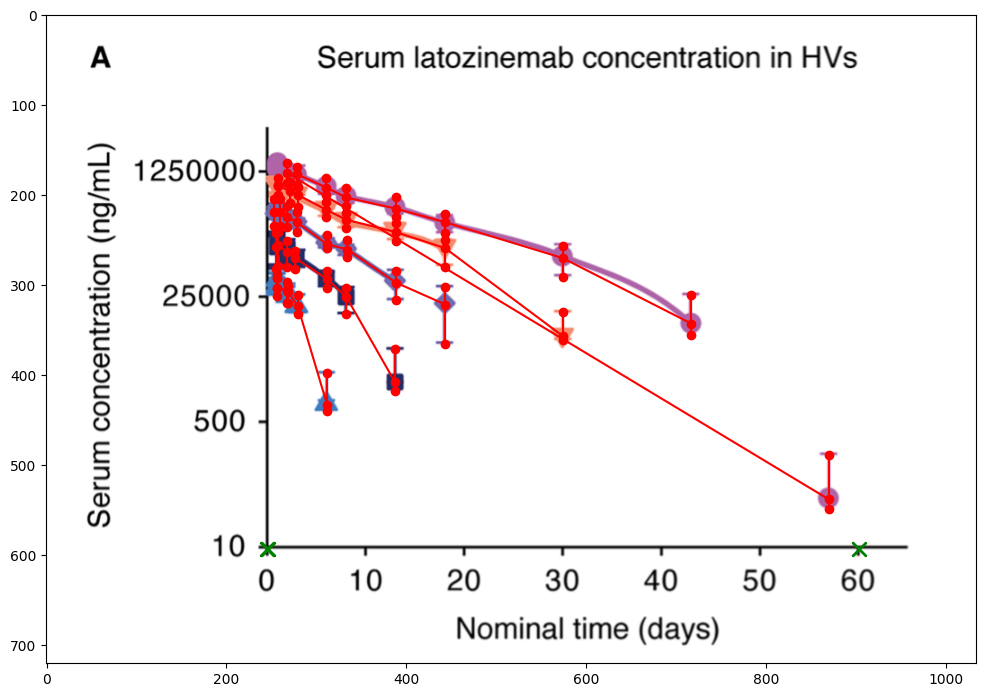

In [22]:
visualize_sample(145)

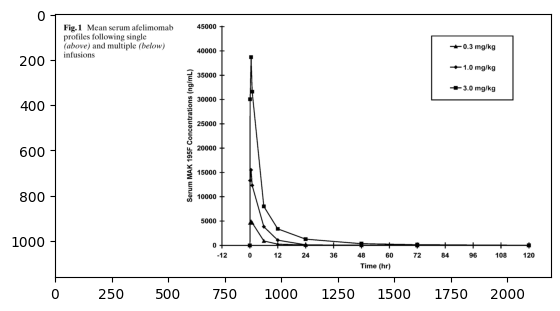

In [21]:
img = plt.imread(dataset[8].image_path)
plt.imshow(img)

# Dataset comparison

Loading Synthetic from 3000 files...


Reading Synthetic: 100%|██████████| 3000/3000 [00:43<00:00, 69.12it/s] 


Loading Real (Cleaned) from 150 files...


Reading Real (Cleaned): 100%|██████████| 150/150 [00:01<00:00, 112.87it/s]



--- Synthetic Statistics ---
Total Points:   134086
Missing Bars:   68151 (50.8%)
Real Bars:      65935 (49.2%)
  - Mean Length: 34.29 px
  - Median Len:  19.03 px
  - Max Length:  878.51 px

--- Real Statistics ---
Total Points:   13468
Missing Bars:   6042 (44.9%)
Real Bars:      7426 (55.1%)
  - Mean Length: 27.70 px
  - Median Len:  12.93 px
  - Max Length:  367.71 px


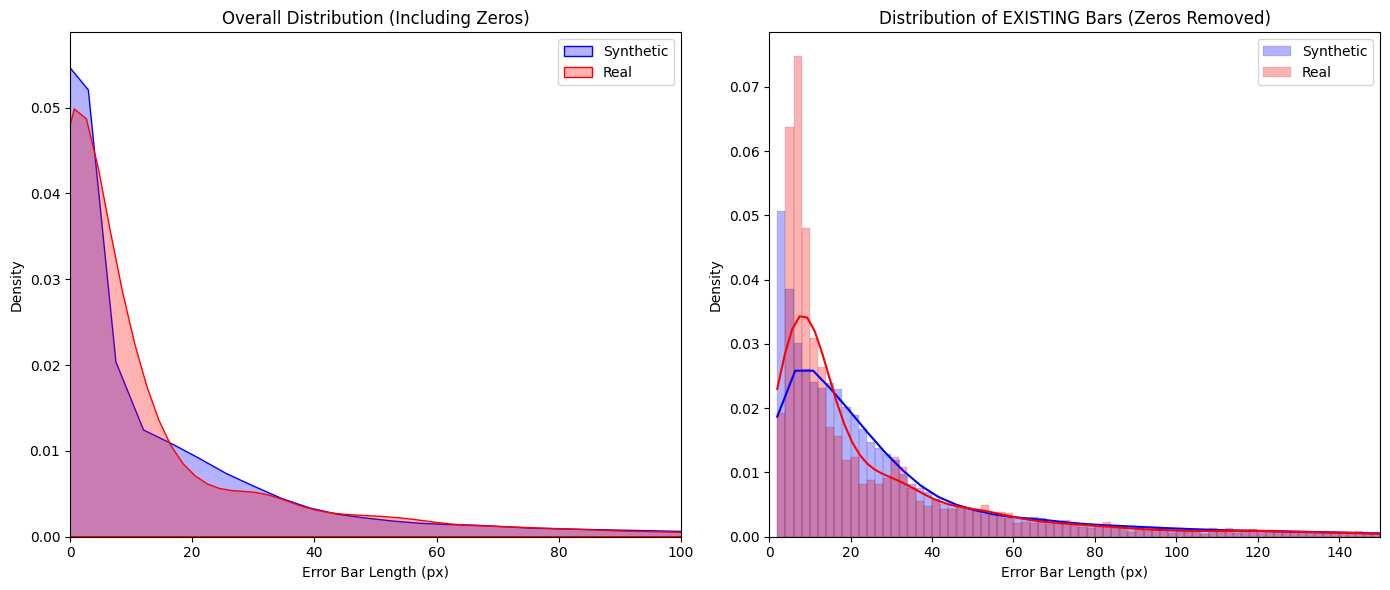

In [24]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

# --- Configuration ---
# Adjust these paths if necessary
ROOT_DIR = Path(".")
SYNTHETIC_LABELS_DIR = ROOT_DIR / "data" / "generated" / "labels"
REAL_LABELS_DIR = ROOT_DIR / "data" / "cleaned" / "labels" # or "data/raw/labels"

def load_bar_lengths(label_dir, name="Dataset"):
    """Reads all JSON files in a directory and extracts error bar lengths."""
    if not label_dir.exists():
        print(f"⚠️ Warning: {label_dir} not found. Skipping {name}.")
        return np.array([])

    lengths = []
    files = list(label_dir.glob("*.json"))

    print(f"Loading {name} from {len(files)} files...")
    for p in tqdm(files, desc=f"Reading {name}"):
        try:
            with open(p, "r") as f:
                data = json.load(f)

            # Handle list of lines (Standard Generator Output)
            if isinstance(data, list):
                for line in data:
                    for point in line.get("points", []):
                        lengths.append(point.get("topBarPixelDistance", 0))
                        lengths.append(point.get("bottomBarPixelDistance", 0))
            # Handle potential dictionary format (if different)
            elif isinstance(data, dict):
                 # Fallback logic if your raw data has a different structure
                 pass

        except Exception as e:
            continue

    return np.array(lengths)

# --- 1. Load Data ---
synth_lengths = load_bar_lengths(SYNTHETIC_LABELS_DIR, "Synthetic")
real_lengths = load_bar_lengths(REAL_LABELS_DIR, "Real (Cleaned)")

# --- 2. Calculate Statistics ---
def print_stats(name, data):
    if len(data) == 0: return

    # We define "Zero" as < 2.0 pixels to account for float noise
    zeros = np.sum(data < 2.0)
    non_zeros = data[data >= 2.0]

    print(f"\n--- {name} Statistics ---")
    print(f"Total Points:   {len(data)}")
    print(f"Missing Bars:   {zeros} ({zeros/len(data)*100:.1f}%)")
    print(f"Real Bars:      {len(non_zeros)} ({len(non_zeros)/len(data)*100:.1f}%)")
    if len(non_zeros) > 0:
        print(f"  - Mean Length: {np.mean(non_zeros):.2f} px")
        print(f"  - Median Len:  {np.median(non_zeros):.2f} px")
        print(f"  - Max Length:  {np.max(non_zeros):.2f} px")

print_stats("Synthetic", synth_lengths)
print_stats("Real", real_lengths)

# --- 3. Plot Distributions ---
if len(synth_lengths) > 0 and len(real_lengths) > 0:
    plt.figure(figsize=(14, 6))

    # Plot A: Full Distribution (Checking for Zero Imbalance)
    plt.subplot(1, 2, 1)
    sns.kdeplot(synth_lengths, fill=True, label='Synthetic', color='blue', alpha=0.3)
    sns.kdeplot(real_lengths, fill=True, label='Real', color='red', alpha=0.3)
    plt.title("Overall Distribution (Including Zeros)")
    plt.xlabel("Error Bar Length (px)")
    plt.xlim(0, 100) # Zoom in on the critical 0-100px range
    plt.legend()

    # Plot B: Non-Zero Distribution (Checking for Length/Grid Line Bias)
    # We filter out the zeros to see what the *actual* bars look like
    plt.subplot(1, 2, 2)
    synth_nonzero = synth_lengths[synth_lengths >= 2.0]
    real_nonzero = real_lengths[real_lengths >= 2.0]

    sns.histplot(synth_nonzero, stat="density", kde=True, label='Synthetic', color='blue', alpha=0.3, binwidth=2)
    sns.histplot(real_nonzero, stat="density", kde=True, label='Real', color='red', alpha=0.3, binwidth=2)

    plt.title("Distribution of EXISTING Bars (Zeros Removed)")
    plt.xlabel("Error Bar Length (px)")
    plt.xlim(0, 150)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("\n❌ Comparison skipped: One or both datasets are empty.")

# Padding Logic

In [7]:
import os
from src.common.io import load_dataset

dataset = load_dataset(DATASET_PATH / 'cleaned')

Loading dataset from /content/drive/MyDrive/Delineate/data/cleaned...


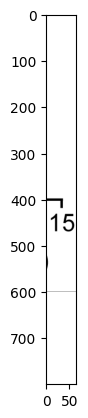

In [27]:
from matplotlib import pyplot as plt
from PIL import Image
import json
from src.detection.dataset import pad_and_crop
from src.config import PATCH_W, PATCH_H

image = dataset[21]
img = plt.imread(image.image_path)

cx = int(image.lines[0].points[3].x)
cy = int(image.lines[0].points[3].y)

with Image.open(image.image_path) as Img:
  patch = pad_and_crop(Img, cx, cy, PATCH_H, PATCH_W)

plt.imshow(patch)

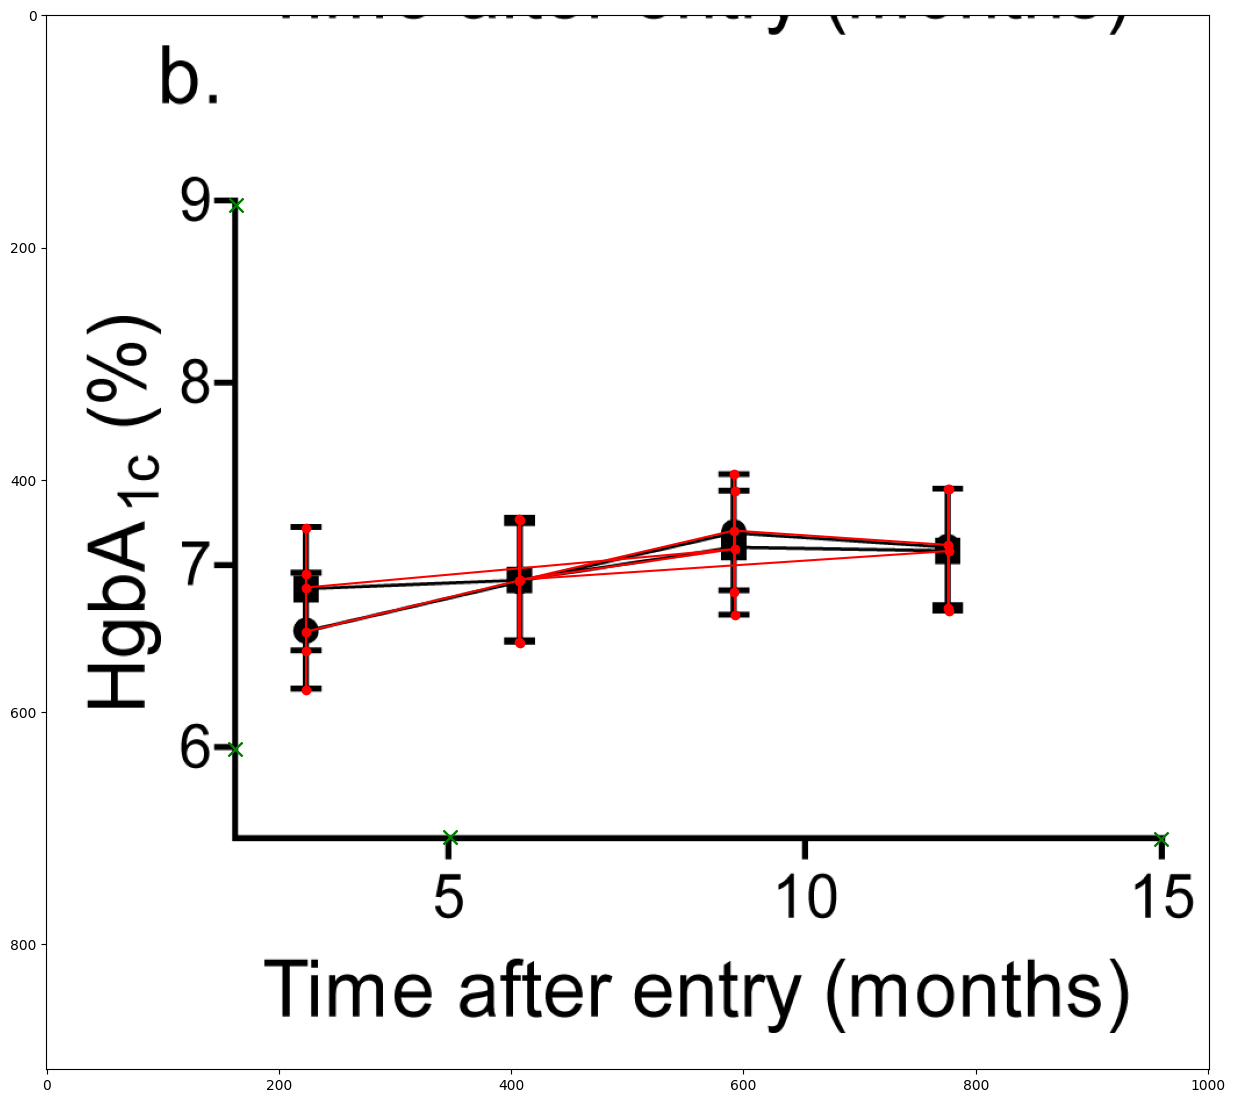

In [30]:
visualize_sample(21)